In [ ]:
import string

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import pandas as pd

from tqdm import tqdm
tqdm.pandas()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab/ethnicolor/data/cnn_full_names_clean.csv")

In [ ]:
df.head()

,full_name
0,Monika Skolimowska
1,Ryan Green
2,Nancy Nydam
3,Briton Macer Gifford
4,Walidah Imarisha


In [ ]:
df['full_name'] = df['full_name'].str.replace("[^a-zA-Z' -]", '', regex=True)

In [ ]:
df['full_name'] = df['full_name'].str.strip()

In [ ]:
df.head()

,full_name
0,Monika Skolimowska
1,Ryan Green
2,Nancy Nydam
3,Briton Macer Gifford
4,Walidah Imarisha


In [ ]:
max_name = 47
all_categories = ['nh_white', 'nh_black', 'other', 'hispanic', 'asian']
n_categories = len(all_categories)
all_letters = string.ascii_letters + "'- "
n_letters = len(all_letters)
oob = n_letters + 1
vocab_size = n_letters + 2

In [ ]:
# A custom Dataset class must implement three functions: __init__, __len__, and __getitem__

class EthniColorDataset(Dataset):
  def __init__(self, data_df, transform=None):
    self.df = data_df
    self.transform = transform

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    name = self.df.iloc[idx, 0]
    if self.transform:
      name_ids = self.transform(name)
    return name, name_ids

In [ ]:
def letterToIndex(letter):
    return all_letters.find(letter)

def lineToTensor(line):
    # if name is more than max_name
    if len(line) > max_name:
      line = line[:max_name]
    tensor = torch.ones(max_name) * oob
    for li, letter in enumerate(line):
        tensor[li] = letterToIndex(letter)
    return tensor

In [ ]:
dataset = EthniColorDataset(df, lineToTensor)

In [ ]:
for i in range(3):
  name, ids  = dataset[i]
  print(i, name, ids)

0 Monika Skolimowska tensor([38., 14., 13.,  8., 10.,  0., 54., 44., 10., 14., 11.,  8., 12., 14.,
        22., 18., 10.,  0., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
1 Ryan Green tensor([43., 24.,  0., 13., 54., 32., 17.,  4.,  4., 13., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])
2 Nancy Nydam tensor([39.,  0., 13.,  2., 24., 54., 39., 24.,  3.,  0., 12., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56., 56.,
        56., 56., 56., 56., 56.])


In [ ]:
batch_size=1024

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=12)

In [ ]:
for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, len(sample_batched[0]), sample_batched[1].size())
    if i_batch == 2:
        break

0 1024 torch.Size([1024, 47])
1 1024 torch.Size([1024, 47])
2 1024 torch.Size([1024, 47])


In [ ]:
# Set the random seed for reproducible results
torch.manual_seed(42)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The nn.Embedding layer returns a new tensor with dimension (sequence_length, 1, hidden_size)
        self.embedding = nn.Embedding(input_size, hidden_size)
        # LSTM layer expects a tensor of dimension (batch_size, sequence_length, hidden_size).
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        embedded = self.embedding(input.type(torch.IntTensor).to(input.device))
        # embedded = embedded.view(embedded.shape[0],-1,embedded.shape[3])
        h0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        c0 = torch.zeros(self.num_layers, embedded.size(0), self.hidden_size).to(input.device)
        out, _ = self.lstm(embedded, (h0, c0))
        out = out[:, -1, :]  # get the output of the last time step
        out = self.fc(out)
        out = self.softmax(out)
        return out


n_hidden = 256
seq_len = max_name
vocab_size = n_letters + 2

model = LSTM(vocab_size, n_hidden, n_categories, num_layers=2)
model.load_state_dict(torch.load('/content/drive/MyDrive/Colab/ethnicolor/models/lstm_FullName_pytorch_81_acc_2layers.pt', map_location=device))
model.to(device)

LSTM(
  (embedding): Embedding(57, 256)
  (lstm): LSTM(256, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=256, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)

In [ ]:
# Set the model to evaluation mode
model.eval()

# Disable gradient calculations
with torch.no_grad():
    # List to hold the predictions
    predictions = []
    names = []

    # Loop over the batches
    for batch in tqdm(dataloader):
        # Move the batch to the device the model is on
        nms = list(batch[0])
        tns = batch[1].to(device)
        # Compute the predictions
        outputs = model(tns)
        outputs = torch.argmax(outputs, dim=1)
        # Move the predictions to the CPU and convert to numpy arrays
        outputs = outputs.cpu().numpy()
        # Append the predictions to the list
        predictions.extend(list(outputs))
        names.extend(nms)

100%|██████████| 65/65 [00:02<00:00, 25.87it/s]


In [ ]:
results_df = pd.DataFrame({'names': names, 'predictions':predictions})

In [ ]:
results_df.head()

,names,predictions
0,Courtesy Roger Williams,1
1,Lori Bourbonais,0
2,Harry Belafonte,1
3,Anthony Casale,1
4,Jeff Cohen,1


In [ ]:
results_df['preds'] = results_df['predictions'].apply(lambda x: all_categories[x])

In [ ]:
results_df.head()

,names,predictions,preds
0,Courtesy Roger Williams,1,nh_black
1,Lori Bourbonais,0,nh_white
2,Harry Belafonte,1,nh_black
3,Anthony Casale,1,nh_black
4,Jeff Cohen,1,nh_black


In [ ]:
results_df.shape

(66560, 3)

In [ ]:
results_df.to_csv("/content/drive/MyDrive/Colab/ethnicolor/data/cnn_news_results.csv", index=False)

In [ ]:
results_df['preds'].value_counts()

nh_white    31456
nh_black    20444
asian        8267
hispanic     4715
other        1678
Name: preds, dtype: int64

In [ ]:
res_dict = results_df['preds'].value_counts().to_dict()

<Axes: >

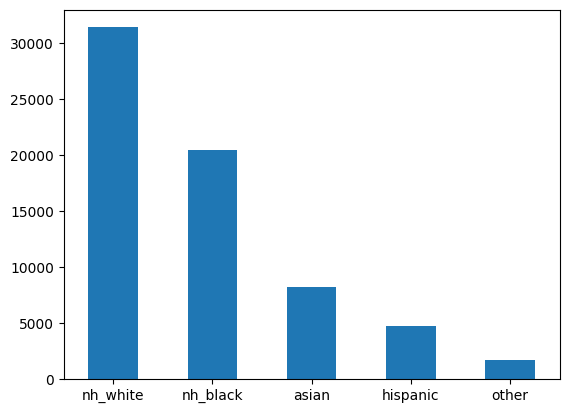

In [ ]:
results_df['preds'].value_counts().plot.bar(x='lab', y='val', rot=0)

In [30]:
results_df.shape

(66560, 3)

In [31]:
results_df.shape[0]

66560

In [32]:
res_dict

{'nh_white': 31456,
 'nh_black': 20444,
 'asian': 8267,
 'hispanic': 4715,
 'other': 1678}

In [33]:
for x in res_dict:
  print(f"{x} - {round(res_dict[x]/results_df.shape[0], 3)}%")

nh_white - 0.473%
nh_black - 0.307%
asian - 0.124%
hispanic - 0.071%
other - 0.025%
